In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [42]:
tr=pd.read_csv('/content/drive/MyDrive/datasets_for_colab/dataset/TRAIN.csv')
test_1=pd.read_csv('/content/drive/MyDrive/datasets_for_colab/dataset/TEST.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
test_1['index1'] = test_1.index

In [44]:
test_Z=test_1.loc[test_1.Open==0]
test_w=test_1.loc[test_1.Open==1]

In [45]:
test_w.shape

(254409, 8)

In [46]:
test_Z.shape

(50754, 8)

In [47]:
train_dr=tr[(tr.Open != 0)&(tr.Sales >0)]

In [48]:
train_dr.shape

(589948, 9)

# store dataset 

In [49]:
d=pd.read_csv('/content/drive/MyDrive/datasets_for_colab/dataset/store.csv')

# feature engneering

In [50]:
d["CompetitionDistance"].fillna(2325.0, inplace = True)

In [51]:
d['CompetitionOpenSinceYear'] = d.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
d['CompetitionOpenSinceMonth'] = d.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
d['Promo2SinceYear'] = d.Promo2SinceYear.fillna(1900).astype(np.int32)
d['Promo2SinceWeek'] = d.Promo2SinceWeek.fillna(1).astype(np.int32)
d['PromoInterval'] =d.PromoInterval.fillna(0)

In [52]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   int32  
 5   CompetitionOpenSinceYear   1115 non-null   int32  
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   int32  
 8   Promo2SinceYear            1115 non-null   int32  
 9   PromoInterval              1115 non-null   object 
dtypes: float64(1), int32(4), int64(2), object(3)
memory usage: 69.8+ KB


In [53]:
joined_tr=pd.merge(train_dr,d,on=['Store'],how='left')

In [54]:
joined_tr.shape

(589948, 18)

In [55]:
joined_tr['SalePerCustomer'] = (joined_tr['Sales']/joined_tr['Customers']).round(2)

In [56]:
joined_tr['weekend']=np.where(joined_tr['DayOfWeek']>5,1,0)

# promotion ratio

In [57]:
b=joined_tr[joined_tr.Promo==1]

In [58]:
j=b.groupby(['Store'])['Sales'].agg(['median'])

In [59]:
j.reset_index(inplace=True)

In [60]:
j.columns=['Store','promo_med']

In [61]:
j.head()

,Store,promo_med
0,1,5140.5
1,2,6308.0
2,3,8528.5
3,4,10319.0
4,5,5899.0


In [62]:
v=joined_tr[joined_tr.Promo==0]
c=v.groupby(['Store'])['Sales'].agg(['median'])

In [63]:
c.reset_index(inplace=True)
c.columns=['Store','nopr_med']
c.head()

,Store,nopr_med
0,1,4018.0
1,2,3981.0
2,3,5328.5
3,4,8798.5
4,5,3710.0


In [64]:
joint=pd.merge(c,j,on='Store')
joint['promo_ratio']=(joint['promo_med']/joint['nopr_med']).round(2)
joint.head()

,Store,nopr_med,promo_med,promo_ratio
0,1,4018.0,5140.5,1.28
1,2,3981.0,6308.0,1.58
2,3,5328.5,8528.5,1.60
3,4,8798.5,10319.0,1.17
4,5,3710.0,5899.0,1.59


In [65]:
first=joint[['Store','promo_ratio']]
first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Store        1115 non-null   int64  
 1   promo_ratio  1115 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.1 KB


In [66]:
joined_tr=pd.merge(joined_tr, first , on=['Store'],how='left')

In [67]:
joined_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589948 entries, 0 to 589947
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      589948 non-null  int64  
 1   DayOfWeek                  589948 non-null  int64  
 2   Date                       589948 non-null  object 
 3   Sales                      589948 non-null  int64  
 4   Customers                  589948 non-null  int64  
 5   Open                       589948 non-null  int64  
 6   Promo                      589948 non-null  int64  
 7   StateHoliday               589948 non-null  object 
 8   SchoolHoliday              589948 non-null  int64  
 9   StoreType                  589948 non-null  object 
 10  Assortment                 589948 non-null  object 
 11  CompetitionDistance        589948 non-null  float64
 12  CompetitionOpenSinceMonth  589948 non-null  int32  
 13  CompetitionOpenSinceYear   58

In [68]:
def q90(x):
    return x.quantile(0.9)


def q25(x):
    return x.quantile(0.25)

def q01(x):
    return x.quantile(0.01)

In [75]:
dr1=joined_tr.groupby(['Store','Promo','weekend'])['Sales'].agg(['median','std',q90,q25,q01])

In [76]:
dr1.head()

median         std     q90      q25      q01
Store Promo weekend                                              
1     0     0        3808.0  876.351157  4708.0  3565.50  2619.40
            1        4757.0  893.767196  6032.6  4355.50  3578.88
      1     0        5140.5  870.627603  6255.2  4651.75  3776.62
2     0     0        4204.5  848.593817  5205.9  3911.25  2409.70
            1        2847.0  507.292402  3437.8  2583.50  2272.14

In [77]:
dr1.reset_index(inplace=True)

In [78]:
dr1.columns=['Store','Promo','weekend','S_median','S_std','S_90','S_25','S_01']

In [79]:
dr1.S_std_n=dr1.S_std.round(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [80]:
dr1.head()

,Store,Promo,weekend,S_median,S_std,S_90,S_25,S_01
0,1,0,0,3808.0,876.351157,4708.0,3565.50,2619.40
1,1,0,1,4757.0,893.767196,6032.6,4355.50,3578.88
2,1,1,0,5140.5,870.627603,6255.2,4651.75,3776.62
3,2,0,0,4204.5,848.593817,5205.9,3911.25,2409.70
4,2,0,1,2847.0,507.292402,3437.8,2583.50,2272.14


In [ ]:
#dr1.info()

In [81]:
joined_tr=pd.merge(joined_tr, dr1, on=['Store','Promo','weekend'],how='left')

In [ ]:
joined_tr.info()

**sales per coustmer groupby**

In [83]:
dr_new=pd.DataFrame(joined_tr.groupby('Store')['SalePerCustomer'].agg(['median']))

In [84]:
dr_new.reset_index(inplace=True)

In [85]:
dr_new.columns=['Store','SC_per_med']

In [86]:
dr_new.SC_per_med=(dr_new.SC_per_med).round(2)

In [87]:
dr_new.head()

,Store,SC_per_med
0,1,8.41
1,2,8.40
2,3,9.15
3,4,7.28
4,5,8.68


In [88]:
dr_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Store       1115 non-null   int64  
 1   SC_per_med  1115 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 17.5 KB


In [89]:
joined_tr=pd.merge(joined_tr, dr_new, on=['Store'],how='left')

In [ ]:
#joined_tr.info()

**extracting from date**

In [90]:
joined_tr["day"] = pd.to_datetime(joined_tr.Date, format="%Y/%m/%d").dt.day

joined_tr["month"] = pd.to_datetime(joined_tr.Date, format="%Y/%m/%d").dt.month

joined_tr["year"] = pd.to_datetime(joined_tr.Date, format="%Y/%m/%d").dt.year

joined_tr["WeekOfYear"] = pd.to_datetime(joined_tr.Date, format="%Y/%m/%d").dt.weekofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [91]:

# competition open time (in months)
joined_tr['CompetitionOpen'] = 12 * (joined_tr.year - joined_tr.CompetitionOpenSinceYear) + \
        (joined_tr.month - joined_tr.CompetitionOpenSinceMonth)

In [92]:
joined_tr['CompetitionOpen'] = joined_tr['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

In [93]:
joined_tr['PromoOpen'] = 12 * (joined_tr.year - joined_tr.Promo2SinceYear) + \
        (joined_tr.WeekOfYear - joined_tr.Promo2SinceWeek) / 4.0

In [94]:
joined_tr['PromoOpen'] = joined_tr['PromoOpen'].apply(lambda x: x if x > 0 else 0)

In [ ]:
#joined_tr.info()

In [ ]:
joined_tr.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [95]:
joined_tr["StateHoliday"].replace(['0','a','b','c',0],[0,1,2,3,0],inplace = True)

joined_tr["StoreType"].replace(['a','b','c','d'],[1,2,3,4],inplace = True)

joined_tr["Assortment"].replace(['a','b','c','d'],[1,2,3,4],inplace = True)

joined_tr["PromoInterval"].replace(['Jan,Apr,Jul,Oct','Feb,May,Aug,Nov','Mar,Jun,Sept,Dec',0],[1,2,3,0],inplace = True)

In [ ]:
joined_tr.info()

**saturday sales ratio**

In [97]:
op=joined_tr.loc[joined_tr.DayOfWeek==6]

In [98]:
h=op.groupby(['Store'])['Sales'].agg(['median'])
h.reset_index(inplace=True)
h.columns=['Store','sat_sales']
h.head()

,Store,sat_sales
0,1,4757.0
1,2,2847.0
2,3,4251.0
3,4,10048.0
4,5,2041.0


In [99]:
b=joined_tr.loc[joined_tr.DayOfWeek!=6]
k=b.groupby(['Store'])['Sales'].agg(['median'])
k.reset_index(inplace=True)
k.columns=['Store','non_sales']

In [100]:
joint_1=pd.merge(k,h,on='Store')
joint_1['sat_ratio']=(joint_1['sat_sales']/joint_1['non_sales']).round(2)
joint_1.head()

,Store,non_sales,sat_sales,sat_ratio
0,1,4563.0,4757.0,1.04
1,2,5149.0,2847.0,0.55
2,3,7301.0,4251.0,0.58
3,4,9353.0,10048.0,1.07
4,5,4990.0,2041.0,0.41


In [101]:
joint_1=joint_1[['Store','sat_ratio']]

In [103]:
joint_1

,Store,sat_ratio
0,1,1.04
1,2,0.55
2,3,0.58
3,4,1.07
4,5,0.41
...,...,...
1110,1111,0.60
1111,1112,0.88
1112,1113,0.84
1113,1114,1.07


In [104]:
joined_tr=pd.merge(joined_tr,joint_1 , on=['Store'],how='left')

In [ ]:
#joined_tr.info()

**state holiday sales**

In [105]:
mk=joined_tr[joined_tr.StateHoliday!=0]

In [106]:
h1_p1=mk.groupby(['Store'])['Sales'].agg(['mean'])
h1_p1.reset_index(inplace=True)
h1_p1.columns=['Store','hol_sales']
h1_p1

,Store,hol_sales
0,2,2672.500000
1,5,5557.000000
2,6,5461.000000
3,7,3177.500000
4,54,5150.250000
...,...,...
125,1093,9296.500000
126,1097,13437.681818
127,1098,5954.000000
128,1099,4806.100000


In [107]:
h2=joined_tr[joined_tr.StateHoliday==0]

In [108]:
h2_p2=h2.groupby(['Store'])['Sales'].agg(['median'])
h2_p2.reset_index(inplace=True)
h2_p2.columns=['Store','non_h_sales']
h2_p2

,Store,non_h_sales
0,1,4599.5
1,2,4846.5
2,3,6683.5
3,4,9567.0
4,5,4622.5
...,...,...
1110,1111,5031.0
1111,1112,8892.0
1112,1113,6468.0
1113,1114,20747.0


In [ ]:
def hol(x):
  if x.hol_sales==0.0:
    return (0)
  else:
    return ((x['hol_sales']/x['non_h_sales']).round(2))  

In [109]:
jo2=pd.merge(h2_p2,h1_p1,on='Store',how='left')
jo2=jo2.fillna(0)
jo2

,Store,non_h_sales,hol_sales
0,1,4599.5,0.0
1,2,4846.5,2672.5
2,3,6683.5,0.0
3,4,9567.0,0.0
4,5,4622.5,5557.0
...,...,...,...
1110,1111,5031.0,0.0
1111,1112,8892.0,0.0
1112,1113,6468.0,0.0
1113,1114,20747.0,0.0


In [110]:
jo2['hol_ratio']=(jo2['hol_sales']/jo2['non_h_sales']).round(2)

In [111]:
jo2

,Store,non_h_sales,hol_sales,hol_ratio
0,1,4599.5,0.0,0.00
1,2,4846.5,2672.5,0.55
2,3,6683.5,0.0,0.00
3,4,9567.0,0.0,0.00
4,5,4622.5,5557.0,1.20
...,...,...,...,...
1110,1111,5031.0,0.0,0.00
1111,1112,8892.0,0.0,0.00
1112,1113,6468.0,0.0,0.00
1113,1114,20747.0,0.0,0.00


In [112]:
holi_day=jo2[['Store','hol_ratio']]

In [113]:
holi_day.head()

,Store,hol_ratio
0,1,0.00
1,2,0.55
2,3,0.00
3,4,0.00
4,5,1.20


In [114]:
joined_tr=pd.merge(joined_tr,holi_day , on=['Store'],how='left')

In [ ]:
#joined_tr.info()

**school holiday sales**

In [115]:
mk=joined_tr[joined_tr.SchoolHoliday==1]

In [116]:
h1_p1=mk.groupby(['Store'])['Sales'].agg(['median'])
h1_p1.reset_index(inplace=True)
h1_p1.columns=['Store','hol_sales']
h1_p1

,Store,hol_sales
0,1,4574.0
1,2,5274.5
2,3,7184.5
3,4,10000.0
4,5,4685.5
...,...,...
1110,1111,4903.5
1111,1112,9170.0
1112,1113,6608.0
1113,1114,21304.0


In [117]:
h2=joined_tr[joined_tr.SchoolHoliday==0]

In [118]:
h2_p2=h2.groupby(['Store'])['Sales'].agg(['median'])
h2_p2.reset_index(inplace=True)
h2_p2.columns=['Store','non_h_sales']
h2_p2

,Store,non_h_sales
0,1,4602.0
1,2,4764.5
2,3,6519.5
3,4,9411.0
4,5,4607.0
...,...,...
1110,1111,5041.0
1111,1112,8762.0
1112,1113,6453.5
1113,1114,20569.0


In [119]:
jo2=pd.merge(h2_p2,h1_p1,on='Store',how='left')
jo2=jo2.fillna(0)
jo2

,Store,non_h_sales,hol_sales
0,1,4602.0,4574.0
1,2,4764.5,5274.5
2,3,6519.5,7184.5
3,4,9411.0,10000.0
4,5,4607.0,4685.5
...,...,...,...
1110,1111,5041.0,4903.5
1111,1112,8762.0,9170.0
1112,1113,6453.5,6608.0
1113,1114,20569.0,21304.0


In [120]:
jo2['sc_h_ratio']=(jo2['hol_sales']/jo2['non_h_sales']).round(2)

In [121]:
sc_day=jo2[['Store','sc_h_ratio']]
sc_day

,Store,sc_h_ratio
0,1,0.99
1,2,1.11
2,3,1.10
3,4,1.06
4,5,1.02
...,...,...
1110,1111,0.97
1111,1112,1.05
1112,1113,1.02
1113,1114,1.04


In [122]:
joined_tr=pd.merge(joined_tr,sc_day , on=['Store'],how='left')

In [ ]:
#joined_tr.info()

In [123]:
month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
joined_tr['month_str'] = joined_tr.month.map(month2str)

In [124]:
def check(row):
    if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
          return 1
    else:
          return 0

In [125]:
joined_tr['IsPromoMonth'] =  joined_tr.apply(lambda row: check(row),axis=1) 

In [126]:
joined_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589948 entries, 0 to 589947
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      589948 non-null  int64  
 1   DayOfWeek                  589948 non-null  int64  
 2   Date                       589948 non-null  object 
 3   Sales                      589948 non-null  int64  
 4   Customers                  589948 non-null  int64  
 5   Open                       589948 non-null  int64  
 6   Promo                      589948 non-null  int64  
 7   StateHoliday               589948 non-null  int64  
 8   SchoolHoliday              589948 non-null  int64  
 9   StoreType                  589948 non-null  int64  
 10  Assortment                 589948 non-null  int64  
 11  CompetitionDistance        589948 non-null  float64
 12  CompetitionOpenSinceMonth  589948 non-null  int32  
 13  CompetitionOpenSinceYear   58

# test dataset

In [209]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589948 entries, 0 to 589947
Data columns (total 44 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      589948 non-null  int64  
 1   DayOfWeek                  589948 non-null  int64  
 2   Promo                      589948 non-null  int64  
 3   StateHoliday               589948 non-null  int64  
 4   SchoolHoliday              589948 non-null  int64  
 5   StoreType                  589948 non-null  int64  
 6   Assortment                 589948 non-null  int64  
 7   CompetitionDistance        589948 non-null  float64
 8   CompetitionOpenSinceMonth  589948 non-null  int32  
 9   CompetitionOpenSinceYear   589948 non-null  int32  
 10  Promo2                     589948 non-null  int64  
 11  Promo2SinceWeek            589948 non-null  int32  
 12  Promo2SinceYear            589948 non-null  int32  
 13  PromoInterval              58

In [218]:
joined_test=pd.merge(test_w,d,on=['Store'],how='left')

In [219]:
joined_test['weekend']=np.where(joined_test['DayOfWeek']>5,1,0)

In [220]:
joined_test=pd.merge(joined_test,first,on=['Store'],how='left')

joined_test=pd.merge(joined_test,dr1,on=['Store','Promo','weekend'],how='left')


joined_test=pd.merge(joined_test,dr_new,on=['Store'],how='left')






In [222]:
joined_test["day"] = pd.to_datetime(joined_test.Date, format="%Y/%m/%d").dt.day

joined_test["month"] = pd.to_datetime(joined_test.Date, format="%Y/%m/%d").dt.month

joined_test["year"] = pd.to_datetime(joined_test.Date, format="%Y/%m/%d").dt.year

joined_test["WeekOfYear"] = pd.to_datetime(joined_test.Date, format="%Y/%m/%d").dt.weekofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [224]:
joined_test['CompetitionOpen'] = 12 * (joined_test.year - joined_test.CompetitionOpenSinceYear) + \
        (joined_test.month - joined_test.CompetitionOpenSinceMonth)
joined_test['CompetitionOpen'] = joined_test['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)



In [225]:
joined_test['PromoOpen'] = 12 * (joined_test.year - joined_test.Promo2SinceYear) + \
        (joined_test.WeekOfYear - joined_test.Promo2SinceWeek) / 4.0
joined_test['PromoOpen'] = joined_test['PromoOpen'].apply(lambda x: x if x > 0 else 0)        

In [227]:
joined_test=pd.merge(joined_test,joint_1,on=['Store'],how='left')

joined_test=pd.merge(joined_test,holi_day,on=['Store'],how='left')

joined_test=pd.merge(joined_test,sc_day,on=['Store'],how='left')

In [228]:
joined_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254409 entries, 0 to 254408
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      254409 non-null  int64  
 1   DayOfWeek                  254409 non-null  int64  
 2   Date                       254409 non-null  object 
 3   Open                       254409 non-null  int64  
 4   Promo                      254409 non-null  int64  
 5   StateHoliday               254409 non-null  object 
 6   SchoolHoliday              254409 non-null  int64  
 7   index1                     254409 non-null  int64  
 8   StoreType                  254409 non-null  object 
 9   Assortment                 254409 non-null  object 
 10  CompetitionDistance        254409 non-null  float64
 11  CompetitionOpenSinceMonth  254409 non-null  int32  
 12  CompetitionOpenSinceYear   254409 non-null  int32  
 13  Promo2                     25

In [229]:
joined_test["StateHoliday"].replace(['0','a','b','c',0],[0,1,2,3,0],inplace = True)

joined_test["StoreType"].replace(['a','b','c','d'],[1,2,3,4],inplace = True)

joined_test["Assortment"].replace(['a','b','c','d'],[1,2,3,4],inplace = True)

joined_test["PromoInterval"].replace(['Jan,Apr,Jul,Oct','Feb,May,Aug,Nov','Mar,Jun,Sept,Dec',0],[1,2,3,0],inplace = True)

['Store','Promo','weekend']

In [230]:
month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
joined_test['month_str'] = joined_test.month.map(month2str)

In [231]:
joined_test['IsPromoMonth'] =  joined_test.apply(lambda row: check(row),axis=1) 

In [237]:
joined_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589948 entries, 0 to 589947
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      589948 non-null  int64         
 1   DayOfWeek                  589948 non-null  int64         
 2   Date                       589948 non-null  datetime64[ns]
 3   Sales                      589948 non-null  int64         
 4   Customers                  589948 non-null  int64         
 5   Open                       589948 non-null  int64         
 6   Promo                      589948 non-null  int64         
 7   StateHoliday               589948 non-null  int64         
 8   SchoolHoliday              589948 non-null  int64         
 9   StoreType                  589948 non-null  int64         
 10  Assortment                 589948 non-null  int64         
 11  CompetitionDistance        589948 non-null  float64 

In [146]:
joined_tr['Date']=pd.to_datetime(joined_tr.Date, format="%Y/%m/%d")

In [238]:
joined_test['Date']=pd.to_datetime(joined_test.Date, format="%Y/%m/%d")

# new method

In [233]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [234]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [239]:
df = joined_tr[columns].append(joined_test[columns])

In [240]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [241]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [242]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [243]:
df = df.set_index("Date")

In [244]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [245]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [246]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [247]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [248]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [249]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [250]:
df.reset_index(inplace=True)

In [251]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [252]:
df.drop(columns,1,inplace=True)

In [253]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-07-31,1,0,0,0,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,0,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,0,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,0,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,0,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


In [254]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [166]:
joined_train = join_df(joined_tr, df, ['Store', 'Date'])

In [167]:
joined_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589948 entries, 0 to 589947
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      589948 non-null  int64         
 1   DayOfWeek                  589948 non-null  int64         
 2   Date                       589948 non-null  datetime64[ns]
 3   Sales                      589948 non-null  int64         
 4   Customers                  589948 non-null  int64         
 5   Open                       589948 non-null  int64         
 6   Promo                      589948 non-null  int64         
 7   StateHoliday               589948 non-null  int64         
 8   SchoolHoliday              589948 non-null  int64         
 9   StoreType                  589948 non-null  int64         
 10  Assortment                 589948 non-null  int64         
 11  CompetitionDistance        589948 non-null  float64 

In [255]:
full_test=join_df(joined_test, df, ['Store', 'Date'])

In [256]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254409 entries, 0 to 254408
Data columns (total 48 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      254409 non-null  int64         
 1   DayOfWeek                  254409 non-null  int64         
 2   Date                       254409 non-null  datetime64[ns]
 3   Open                       254409 non-null  int64         
 4   Promo                      254409 non-null  int64         
 5   StateHoliday               254409 non-null  int64         
 6   SchoolHoliday              254409 non-null  int64         
 7   index1                     254409 non-null  int64         
 8   StoreType                  254409 non-null  int64         
 9   Assortment                 254409 non-null  int64         
 10  CompetitionDistance        254409 non-null  float64       
 11  CompetitionOpenSinceMonth  254409 non-null  int32   

# model

In [170]:
train_new_on = joined_train.sort_values(['Date'],ascending = False)

In [171]:
train_new_on['Sales']=np.log1p(train_new_on['Sales'])

In [289]:
train_new_on.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalePerCustomer,weekend,promo_ratio,S_median,S_std,S_90,S_25,S_01,SC_per_med,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen,sat_ratio,hol_ratio,sc_h_ratio,month_str,IsPromoMonth,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,1,5,2015-07-31,8.568646,555,1,1,0,1,3,1,1270.0,9,2008,0,1,1900,0,9.48,0,1.28,5140.5,870.627603,6255.2,4651.75,3776.62,8.41,31,7,2015,31,82,1387.50,1.04,0.0,0.99,Jul,0,0,0,0,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
740,742,5,2015-07-31,9.255409,1016,1,1,0,1,4,3,4380.0,1,1900,0,1,1900,0,10.30,0,1.34,9165.0,1820.418552,12232.2,8390.75,6997.58,9.07,31,7,2015,31,1386,1387.50,0.96,0.0,0.97,Jul,0,0,0,0,0,0,0,6.0,0.0,5.0,1.0,0.0,1.0
746,748,5,2015-07-31,8.920255,578,1,1,0,1,4,1,2380.0,3,2010,1,14,2011,1,12.94,0,1.42,6708.0,1398.026317,8958.3,6045.50,4929.15,11.68,31,7,2015,31,64,52.25,0.91,0.0,1.02,Jul,0,0,0,0,0,0,0,6.0,0.0,5.0,1.0,0.0,1.0
745,747,5,2015-07-31,9.278840,826,1,1,0,1,3,3,45740.0,8,2008,0,1,1900,0,12.96,0,1.42,9342.5,1993.908095,12397.8,8544.25,7025.09,11.38,31,7,2015,31,83,1387.50,0.76,0.0,1.13,Jul,0,0,0,0,0,0,0,6.0,0.0,5.0,1.0,0.0,1.0
744,746,5,2015-07-31,9.114160,638,1,1,0,1,4,3,4330.0,2,2011,1,35,2011,3,14.24,0,1.45,7419.5,1501.732316,9820.3,6553.25,5294.02,11.72,31,7,2015,31,53,47.00,0.96,0.0,1.00,Jul,0,0,0,0,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [290]:
%cd "/content/drive/MyDrive/dok"
train_new_on.to_csv('cleaned_train.csv', index =False)

/content/drive/MyDrive/dok


In [174]:
X=train_new_on.drop(['Sales','Customers','Date','Open','month_str','SalePerCustomer','Open'],axis=1)

In [175]:
X.shape

(589948, 44)

In [ ]:
X.head()

In [ ]:
#X.info()

In [272]:
y=train_new_on.Sales
y

0         8.568646
740       9.255409
746       8.920255
745       9.278840
744       9.114160
            ...   
589715    8.356790
589714    8.830543
589713    8.760923
589712    8.382747
589947    8.723231
Name: Sales, Length: 589948, dtype: float64

In [257]:
re_test_in=full_test.sort_values(by='index1',ascending=True)

In [258]:
re_test_in.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,index1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,weekend,promo_ratio,S_median,S_std,S_90,S_25,S_01,SC_per_med,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen,sat_ratio,hol_ratio,sc_h_ratio,month_str,IsPromoMonth,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,1111,6,2013-03-16,1,0,0,0,1,1,1,1900.0,6,2014,1,31,2013,1,1,1.51,3236.0,690.695950,4013.9,2732.0,2125.47,11.76,16,3,2013,11,0,0.00,0.60,0.0,0.97,Mar,0,71,-9,0,0,8,-2,0.0,0.0,0.0,0.0,0.0,5.0
1,45,4,2013-08-01,1,1,0,1,2,4,1,9710.0,2,2014,0,1,1900,0,0,1.32,5882.5,1076.829184,7731.5,5368.5,4366.93,12.74,1,8,2013,31,0,1363.50,1.07,0.0,0.97,Aug,0,0,0,0,0,0,0,6.0,0.0,4.0,6.0,0.0,2.0
2,500,4,2013-05-23,1,0,0,1,3,4,3,10690.0,9,2007,1,5,2013,1,0,1.09,5023.0,818.362377,5969.2,4579.0,3658.88,13.75,23,5,2013,21,68,4.00,1.18,0.0,0.94,May,0,0,0,0,0,6,-4,3.0,0.0,3.0,6.0,0.0,4.0
3,82,2,2013-08-06,1,0,0,1,4,1,1,22390.0,4,2008,1,37,2009,1,0,1.56,7582.5,1553.982811,9307.0,6942.0,5092.39,10.62,6,8,2013,32,64,46.75,0.58,0.0,1.08,Aug,0,0,0,0,0,4,-6,6.0,0.0,4.0,6.0,0.0,2.0
4,1022,5,2013-03-22,1,1,0,0,6,1,3,1520.0,1,1900,0,1,1900,0,0,1.43,8638.5,1991.756915,12162.6,7646.0,6522.22,8.77,22,3,2013,12,1358,1358.75,0.89,0.0,1.01,Mar,0,77,-3,0,0,0,0,0.0,0.0,5.0,4.0,0.0,5.0


In [291]:
%cd "/content/drive/MyDrive/dok"
re_test_in.to_csv('cleaned_test.csv', index =False)

/content/drive/MyDrive/dok


In [259]:
re_test_in.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254409 entries, 0 to 254408
Data columns (total 48 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      254409 non-null  int64         
 1   DayOfWeek                  254409 non-null  int64         
 2   Date                       254409 non-null  datetime64[ns]
 3   Open                       254409 non-null  int64         
 4   Promo                      254409 non-null  int64         
 5   StateHoliday               254409 non-null  int64         
 6   SchoolHoliday              254409 non-null  int64         
 7   index1                     254409 non-null  int64         
 8   StoreType                  254409 non-null  int64         
 9   Assortment                 254409 non-null  int64         
 10  CompetitionDistance        254409 non-null  float64       
 11  CompetitionOpenSinceMonth  254409 non-null  int32   

In [260]:
full_test_no=re_test_in.drop(['index1','Date','month_str','Open'],axis=1)

In [261]:
full_test_no.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,weekend,promo_ratio,S_median,S_std,S_90,S_25,S_01,SC_per_med,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen,sat_ratio,hol_ratio,sc_h_ratio,IsPromoMonth,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,1111,6,0,0,0,1,1,1900.0,6,2014,1,31,2013,1,1,1.51,3236.0,690.695950,4013.9,2732.0,2125.47,11.76,16,3,2013,11,0,0.00,0.60,0.0,0.97,0,71,-9,0,0,8,-2,0.0,0.0,0.0,0.0,0.0,5.0
1,45,4,1,0,1,4,1,9710.0,2,2014,0,1,1900,0,0,1.32,5882.5,1076.829184,7731.5,5368.5,4366.93,12.74,1,8,2013,31,0,1363.50,1.07,0.0,0.97,0,0,0,0,0,0,0,6.0,0.0,4.0,6.0,0.0,2.0
2,500,4,0,0,1,4,3,10690.0,9,2007,1,5,2013,1,0,1.09,5023.0,818.362377,5969.2,4579.0,3658.88,13.75,23,5,2013,21,68,4.00,1.18,0.0,0.94,0,0,0,0,0,6,-4,3.0,0.0,3.0,6.0,0.0,4.0
3,82,2,0,0,1,1,1,22390.0,4,2008,1,37,2009,1,0,1.56,7582.5,1553.982811,9307.0,6942.0,5092.39,10.62,6,8,2013,32,64,46.75,0.58,0.0,1.08,0,0,0,0,0,4,-6,6.0,0.0,4.0,6.0,0.0,2.0
4,1022,5,1,0,0,1,3,1520.0,1,1900,0,1,1900,0,0,1.43,8638.5,1991.756915,12162.6,7646.0,6522.22,8.77,22,3,2013,12,1358,1358.75,0.89,0.0,1.01,0,77,-3,0,0,0,0,0.0,0.0,5.0,4.0,0.0,5.0


In [208]:
X.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,weekend,promo_ratio,S_median,S_std,S_90,S_25,S_01,SC_per_med,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen,sat_ratio,hol_ratio,sc_h_ratio,IsPromoMonth,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,1,5,1,0,1,3,1,1270.0,9,2008,0,1,1900,0,0,1.28,5140.5,870.627603,6255.2,4651.75,3776.62,8.41,31,7,2015,31,82,1387.50,1.04,0.0,0.99,0,0,0,0,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
740,742,5,1,0,1,4,3,4380.0,1,1900,0,1,1900,0,0,1.34,9165.0,1820.418552,12232.2,8390.75,6997.58,9.07,31,7,2015,31,1386,1387.50,0.96,0.0,0.97,0,0,0,0,0,0,0,6.0,0.0,5.0,1.0,0.0,1.0
746,748,5,1,0,1,4,1,2380.0,3,2010,1,14,2011,1,0,1.42,6708.0,1398.026317,8958.3,6045.50,4929.15,11.68,31,7,2015,31,64,52.25,0.91,0.0,1.02,0,0,0,0,0,0,0,6.0,0.0,5.0,1.0,0.0,1.0
745,747,5,1,0,1,3,3,45740.0,8,2008,0,1,1900,0,0,1.42,9342.5,1993.908095,12397.8,8544.25,7025.09,11.38,31,7,2015,31,83,1387.50,0.76,0.0,1.13,0,0,0,0,0,0,0,6.0,0.0,5.0,1.0,0.0,1.0
744,746,5,1,0,1,4,3,4330.0,2,2011,1,35,2011,3,0,1.45,7419.5,1501.732316,9820.3,6553.25,5294.02,11.72,31,7,2015,31,53,47.00,0.96,0.0,1.00,0,0,0,0,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [ ]:
#full_test_no.info()

In [ ]:
full_test_no.info()

In [ ]:
X.info()

In [263]:
full_test_no.shape

(254409, 44)

In [273]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [185]:
from sklearn.metrics import mean_squared_log_error
from math import sqrt

In [186]:
import lightgbm as lgb
train_data = lgb.Dataset(X, label=y)
test_data = lgb.Dataset(X_test, label=y_test)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.1, 
         'num_iterations': 3000,
         'num_leaves': 69,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.90,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.90,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 1000
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_test)
print('RMSE:', (mean_squared_log_error(np.expm1(y_test), np.expm1(y_pred_lgbm))))

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 0.101537
[200]	valid_0's rmse: 0.0938725
[300]	valid_0's rmse: 0.0898122
[400]	valid_0's rmse: 0.0868147
[500]	valid_0's rmse: 0.0843678
[600]	valid_0's rmse: 0.0824038
[700]	valid_0's rmse: 0.0808513
[800]	valid_0's rmse: 0.0793438
[900]	valid_0's rmse: 0.0778931
[1000]	valid_0's rmse: 0.0766555
[1100]	valid_0's rmse: 0.075471
[1200]	valid_0's rmse: 0.0744804
[1300]	valid_0's rmse: 0.0735108
[1400]	valid_0's rmse: 0.0725665
[1500]	valid_0's rmse: 0.0717203
[1600]	valid_0's rmse: 0.0708934
[1700]	valid_0's rmse: 0.0701202
[1800]	valid_0's rmse: 0.0693774
[1900]	valid_0's rmse: 0.0686968
[2000]	valid_0's rmse: 0.0680465
[2100]	valid_0's rmse: 0.0674016
[2200]	valid_0's rmse: 0.0667835
[2300]	valid_0's rmse: 0.0662125
[2400]	valid_0's rmse: 0.0656449
[2500]	valid_0's rmse: 0.0651162
[2600]	valid_0's rmse: 0.0645957
[2700]	valid_0's rmse: 0.0641036
[2800]	valid_0's rmse: 0.0636071
[2900]	valid_0's rmse: 0

In [203]:
y_pred_lgbm

array([9.14636784, 8.85350605, 8.33575189, ..., 8.33837064, 8.753979  ,
       9.02742358])

In [206]:
y=np.expm1(y_pred_lgbm).round(0)
y

array([9379., 6998., 4169., ..., 4180., 6335., 8327.])

In [204]:
y_pred_lgbm_t

array([7.46103316, 7.69278817, 7.77183136, ..., 7.6112512 , 7.52703797,
       7.55333764])

In [265]:
y_pred_lgbm_t = lgbm.predict(full_test_no)
y_pred_lgbm_t

array([8.13256497, 8.70787395, 8.33818979, ..., 8.20695871, 7.87245881,
       8.64700979])

In [266]:
y_lg=np.expm1(y_pred_lgbm_t).round(0)
y_lg

array([3403., 6049., 4180., ..., 3665., 2623., 5692.])

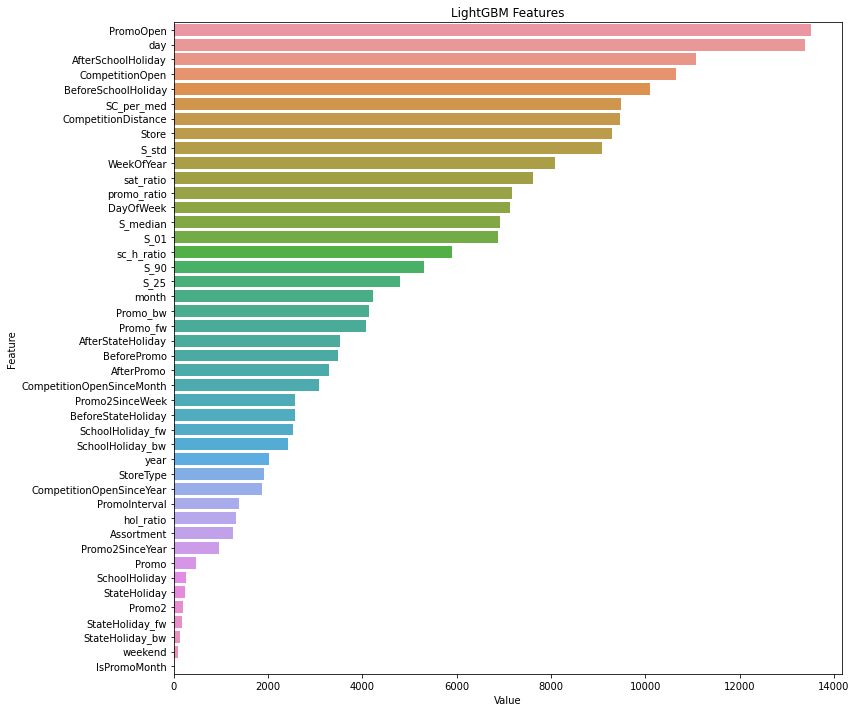

In [267]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [274]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))
    p = lgbm.predict(full_test_no)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.07885011139199942


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.07909096773416469


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.07905497772566265


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.07800657925229386


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.08067066939233529


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.07796859164124877


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.07933080302988456


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.07784667135361407


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.0791153500307603


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.07898768206498244


In [281]:
gb_fib = np.expm1(np.mean(y_pred_totlgb,0))
gb_fib

array([3430.66627866, 5983.49830731, 4116.9220232 , ..., 3659.27588104,
       2705.5253651 , 5858.13963818])

In [282]:
final_data1 = {'Index ': re_test_in.index1, 'Response':gb_fib }
submission7 = pd.DataFrame(data=final_data1)

In [283]:
final_data1 = {'Index ':test_Z.index1, 'Response':0 }
submission_od = pd.DataFrame(data=final_data1)

In [284]:
gb_fib_j= pd.concat([submission7, submission_od])

In [285]:
gb_fib_j= gb_fib_j.sort_values(by=['Index '],ascending=True)

In [286]:
gb_fib_j

,Index,Response
0,0,0.000000
0,1,3430.666279
1,2,5983.498307
2,3,4116.922023
3,4,7062.595282
...,...,...
254404,305158,9721.060637
254405,305159,6910.296432
254406,305160,3659.275881
254407,305161,2705.525365


In [288]:
%cd "/content/drive/MyDrive/dok"
gb_fib_j.to_csv('up_submission.csv', index =False)

/content/drive/MyDrive/dok
